![title](img/twit.png)

# TWITTER

Description du concours
Twitter est devenu un canal de communication important en cas d'urgence.
L'omniprésence des smartphones permet aux gens d'annoncer une urgence qu'ils observent en temps réel. Pour cette raison, de plus en plus d'agences sont intéressées par une surveillance programmatique de Twitter.

Mais, il n'est pas toujours clair si les paroles d'une personne annoncent réellement une catastrophe.

L'auteur utilise explicitement le mot « ABLAZE » (en feu) mais le signifie métaphoriquement. C'est tout de suite clair pour un humain, surtout avec l'aide visuelle. Mais c'est moins clair pour une machine.

Dans ce concours, vous êtes mis au défi de créer un modèle d'apprentissage automatique qui prédit quels Tweets concernent de véritables catastrophes et lesquels ne le sont pas. Nous avons accès à un ensemble de données de 10 000 tweets classés manuellement.

In [1]:
!pip install missingno -q
!pip install wordcloud -q
!pip install -U spacy -q
!python -m spacy download en_core_web_sm -q
!pip install tensorflow -q
import pandas as pd 
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import pathlib 
import os
import io
import tensorflow as tf 
from sklearn.model_selection import train_test_split
import warnings
import spacy
from spacy.lang.en.examples import sentences 
import re 
import en_core_web_sm
from keras import regularizers
from keras.layers.recurrent import LSTM
nlp = spacy.load("en_core_web_sm")
from spacy.lang.en.stop_words import STOP_WORDS
warnings.filterwarnings('ignore')

2021-10-24 21:00:41.849032: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-24 21:00:41.849088: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
data = pd.read_csv('train (1).csv', encoding='utf8')
data = data.sample(7613)
data.drop(['id', 'keyword','location'], axis=1, inplace = True)

,text,target
6904,I'm slightly traumatised after this week's one...,0
6797,#breakingnews Rly tragedy in MP: Some live to ...,1
5643,http://t.co/eHKLp12yiP Paci?c Media Centre | a...,0
201,http://t.co/FueRk0gWui Twelve feared killed in...,1
3081,I'm not the mom friend but I still see my frie...,0
...,...,...
6645,@ShipsXAnchors IDEK HOW IS THERE PEOPLE WHO A...,0
3728,Nothing to fear. It's all about taking risks.,1
1020,HOBO Hobo Vintage Shira Convertible BÛ_ $238....,0
4930,@RaynbowAffair Editor In Chief @DiamondKesawn ...,0


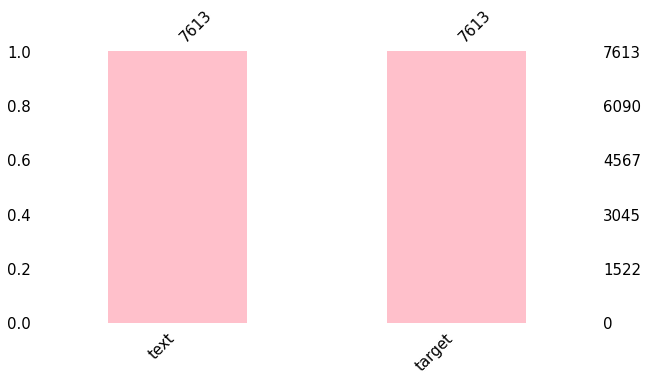

In [3]:
msno.bar(data,figsize=(10, 5),fontsize=15,color='pink');
data

On remarque que nous avons 2 533 valeurs manquantes dans notre colonne location.
Nous retirons également la colonne id, keyword, et location qui ne nous apporte pas d'informations importantes pour notre prédiction 

In [4]:
#supprime les emojis
emoji_pattern = u"\U0001F600-\U0001F64F]+"
data["text_clean"] = data["text"].apply(lambda x:re.sub(emoji_pattern, '', x))
#supprime les url
data["text_clean"] = data["text_clean"].apply(lambda x: re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', x, flags=re.MULTILINE))
# supprime les caratères spéciaux
data["text_clean"] = data["text_clean"].apply(lambda x: re.sub(r'\W', ' ', x))
# supprime les doubles espaces 
data["text_clean"] = data["text_clean"].apply(lambda x:re.sub(r'\s+', ' ', x))
# supprime les /n ou autre
data["text_clean"] = data["text_clean"].apply(lambda x:re.sub("\s+"," ",x).lower().strip())
# supprimer les chiffres 
data["text_clean"] = data["text_clean"].apply(lambda x:re.sub(r"(\b|\s+\-?|^\-?)(\d+|\d*\.\d+)\b","",x ))
# supprime les majuscules
data['text_clean'] = data['text_clean'].fillna('').apply(lambda x: x.lower())
#supprime tous les caractères de nos chaînes qui ne sont pas alphanumériques
data['text_clean']= data["text_clean"].apply(lambda x:[element for element in x if element.isalnum() or element==" "])
data['text_clean']=data["text_clean"].apply(lambda x:"".join([element for element in x if element.isalnum() or element==" "]))
#supprime les éléments atypiques
data["text_clean"] = data["text_clean"].str.replace('û', '').str.replace(' s ','').str.replace(' amp ','').str.replace(' rt ','')
#supprime tous les stop_word
STOP_WORDS.update(['new','news','m','like','don t',' rt ',' a ',' t ',' don ','think','know','day'])
data["text_clean"] = data["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))

nous avons retiré tous les caractères qui ne sont pas alphanumériques, les chiffres, les majuscules, les doubles espaces, les caractères spéciaux, ainsi que les URL et les stop_word qui sont des mots sans aucune valeur ce qui permettra au modèle de ne pas être dérouté. 

In [5]:
#lemmatisation 
data['text_clean']=data["text_clean"].apply(lambda x:[token.lemma_ for token in nlp(x) if token.lemma_ not in STOP_WORDS and token.text not in STOP_WORDS])

Nous allons également faire la lemmatisation pour que notre modèle reconnaisse la racine de nos mots qu'ils soient conjugués ou non.

In [6]:
# Création d'une instance de tokenize
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(data["text_clean"])

# Tokenization + Encoding
data["encoded"] = tokenizer.texts_to_sequences(data["text_clean"])
data.head()

,text,target,text_clean,encoded
6904,I'm slightly traumatised after this week's one...,0,"[slightly, traumatise, weekone, bear]","[1500, 333, 5309, 748]"
6797,#breakingnews Rly tragedy in MP: Some live to ...,1,"[breakingnew, rly, tragedy, mp, live, recount,...","[2282, 800, 351, 469, 61, 899, 434, 1013, 548,..."
5643,http://t.co/eHKLp12yiP Paci?c Media Centre | a...,0,"[paci, c, medium, centre, article, australia, ...","[5310, 421, 435, 670, 845, 749, 5311, 1163, 42..."
201,http://t.co/FueRk0gWui Twelve feared killed in...,1,"[fear, kill, pakistani, air, ambulance, helico...","[58, 7, 801, 241, 255, 507, 11]"
3081,I'm not the mom friend but I still see my frie...,0,"[mom, friend, friend, little, baby, care, ll, ...","[549, 313, 313, 197, 242, 352, 119, 127]"


Nous allons maintenant passer par une phase de Tokenisation. Autrement dit, nous allons attribuer un numéro à chacun des mots présents dans nos tweets et les représenter par des séquences.(ex: « Je veux sortir » — -> [2, 6, 3, 7, 8])

In [7]:
# pad sequences
padded_ecoded_text = tf.keras.preprocessing.sequence.pad_sequences(data["encoded"], padding="post")


Un réseau de neurones nécessite d'avoir des entrées de même longueur nous allons également mettre une couche de padding pour que toutes les phrases ont la même taille.(avec l'argument post la valeur padding = 0, est ajoutée à la fin des séquences).

In [8]:
# create the tensorflow dataset
all_encoded_data = tf.data.Dataset.from_tensor_slices((padded_ecoded_text, data["target"].values))

# Train Test Split
TAKE_SIZE = 5000

train_data = all_encoded_data.take(TAKE_SIZE).shuffle(8000)
train_data = train_data.batch(64)

test_data = all_encoded_data.skip(TAKE_SIZE)
test_data = test_data.batch(64)

On crée également en tensor puis nous allons mélanger les données après la création du test et du train grâce au shuffle. Il doit être supérieur au nombre de données de notre dataset pour éviter d'avoir des données rangées, sinon ils risquent de mettre des informations du train dans le test, ce que nous ne voulons surtout pas.

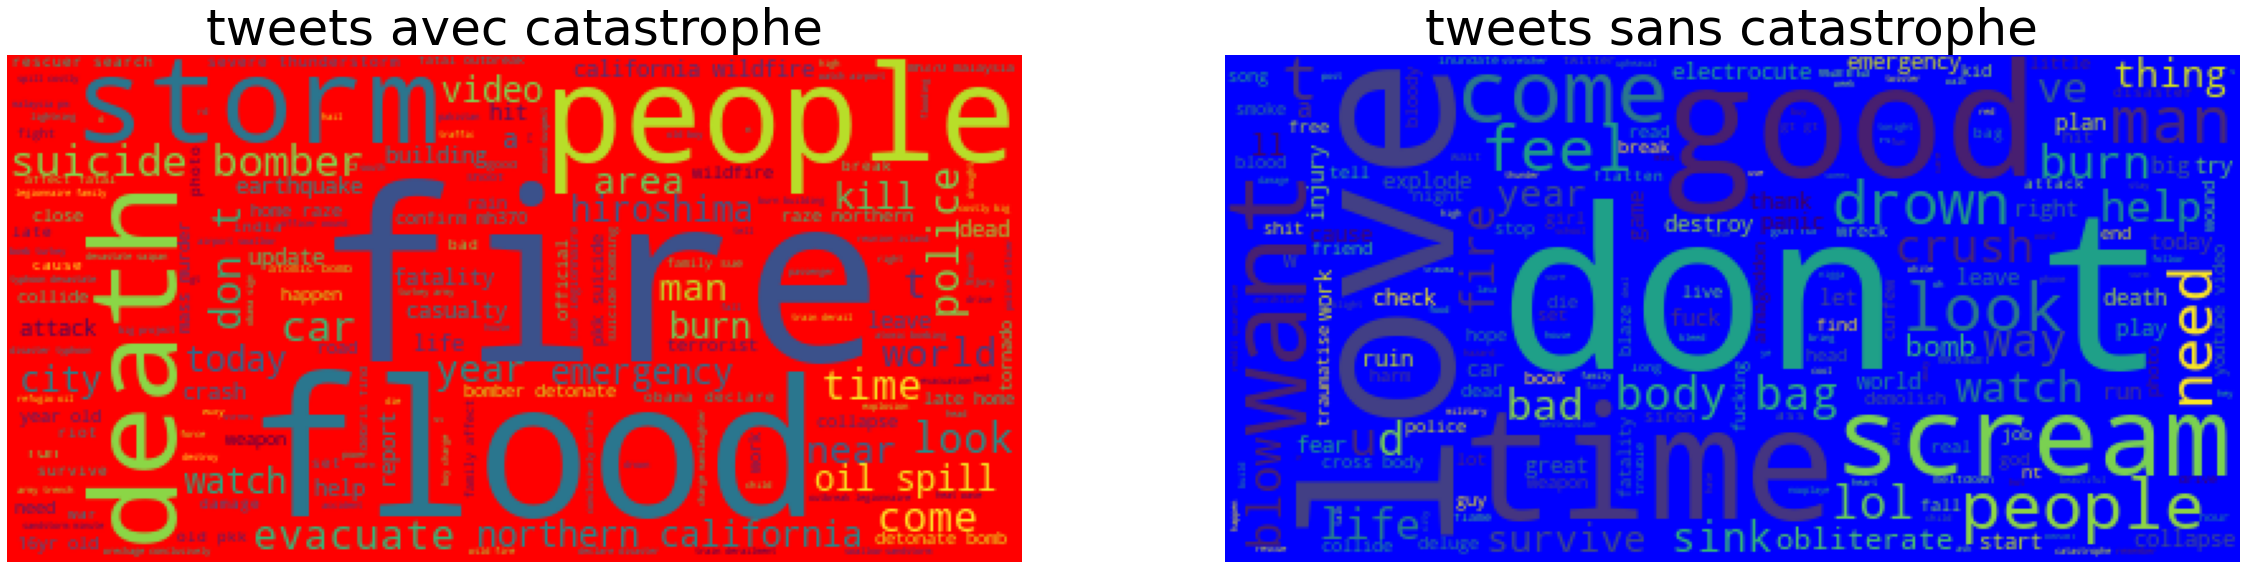

In [9]:
import wordcloud
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(40, 40))

wd = wordcloud.WordCloud(background_color='red',
                         stopwords=STOP_WORDS)
cloud_desastre = wd.generate(' '.join(' '.join(text) for text in data[data.target==1]['text_clean']))

wn = wordcloud.WordCloud(background_color='blue',
                         stopwords=STOP_WORDS)
cloud_non_desastre = wn.generate(' '.join(' '.join(text) for text in data[data.target==0]['text_clean']))

ax1.imshow(cloud_desastre)
ax1.set_title("tweets avec catastrophe", fontsize=50)
ax1.axis('off')

ax2.imshow(cloud_non_desastre)
ax2.set_title("tweets sans catastrophe", fontsize=50)
ax2.axis('off')

fig.show()

Grâce à cette visualisation en nuage de mots, on constate les différents mots qui sont représentés en tant que désastre en rouge et qui ne sont pas considérés comme tels en bleu.  

#  <span style="color:blue">Modélisation</center></span>  


Nous allons utiliser un réseau de neuronne artificiel pour que notre modèle soit capable d'apprendre par lui même contrairement à la programmation ou elle se contente d'exécuter à la lettre les régles prédeterminées.

In [10]:
vocab_size = len(tokenizer.word_index)

model = tf.keras.Sequential([
            tf.keras.layers.Embedding(vocab_size+1, 64),
            tf.keras.layers.GlobalAveragePooling1D(),
            tf.keras.layers.Dense(1, activation='sigmoid')
    ])
model.summary()


# Using a simple compiler with an Adam optimizer to calculate our gradients 
model.compile(optimizer=tf.keras.optimizers.Adam(),#learning_rate=10**-4),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

# Model training
history = model.fit(train_data, epochs=20, validation_data=test_data)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          944192    
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 944,257
Trainable params: 944,257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
79/79 [==============================] - 1s 12ms/step - loss: 0.6778 - binary_accuracy: 0.5564 - val_loss: 0.6573 - val_binary_accuracy: 0.5882
Epoch 2/20
79/79 [==============================] - 1s 10ms/step - loss: 0.6405 - binary_accuracy: 0.6050 - val_loss: 0.6236 - val_binary_accuracy: 0.6789
Epoch 3/20
79/79 [==============================] - 1s 10ms/step - los

Nous commençons par initialiser notre réseau de neuronnes avec Sequential qui regroupe une pile linéaire de calculs dans un fichier tf.keras.Model.

Avec une première couche d'embeding qui est parfaite pour les données textuelles.
La couche d'embeding nous permet de faire une sortie arbitraire et de convertir les mots en vecteur continu qui va aider à l'apprentissage de notre modèle.

(ex : chat = 0, mange = 1 , manger n'est pas supérieur à chat ce n'est pas linéaire )  

Ensuite nous utilisons un GlobalAveragePooling1D qui prend la moyenne des outputs (évite l'overfitting )de chaque phrase de notre Embeding où le vecteur résultant est directement introduit dans la couche sigmoïde que nous utiliserons au final dans notre dernière couche. 

Sur cette dernière, nous utiliserons une sigmoïde car elle lisse les valeurs de sortie qui sont comprises entre 0 et 1 normalisant les sorties de chaque neuronne. Elle est donc identique à notre target et parfaite pour avoir des prédictions claires.

Nous ne mettrons pas de couche de neuronnes supplémentaires car notre modèle deviendrait trop complexe par rapport aux nombres de données que nous possédons. Il apprendrait trop vite et serait en overfiting même avec un learning rate.

Nous avons initialisé un nombre d'epoch à 10 notre modèle va donc regarder et apprendre de chaque batch que nous avons initialisé avant. Une fois qu'il aura regardé les 64 batch cela correspondra à une epoch.
On remarque également que notre modèle apprend assez rapidement en regardant l'accuracy. 9 epoch lui suffisent pour apprendre correctement au-delà notre modèle n'apprend plus, l'accuracy stagne on obtient donc une accuracy à 80%.

On remarque également la val_loss qui est la valeur de la fonction de coût pour nos données de validation croisée et la loss est la valeur de la fonction de coût pour vos données d'entraînement.
Notre modèle essai donc de minimiser ces 2 metrics. Afin de minimiser cette distance, le réseau de neurones apprend également en ajustant les poids et les biais de manière à réduire la perte.

In [11]:
from sklearn.metrics import classification_report
y_true = (data["target"].values)
y_pred = model.predict(padded_ecoded_text)
y_pred = [0 if x <= 0.5 else 1 for x in y_pred]
target_names = ['1', '0']
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.91      0.93      0.92      4342
           1       0.91      0.88      0.89      3271

    accuracy                           0.91      7613
   macro avg       0.91      0.91      0.91      7613
weighted avg       0.91      0.91      0.91      7613



Pour mieux annalyser notre modèle nous utilisons d'autre metrics.

La précision reflète la fiabilité du modèle dans la classification des échantillons.
En d'autres termes, le pourcentage de confiance du modèle lorsqu'il dit qu'un échantillon est non desaster et desaster à 91%.

Concernant le recall il mesure la capacité du modèle à détecter des échantillons positifs. Plus le rappel est élevé, plus les échantillons détectés sont positifs.
Nous avons un recall à 93% et 88%, cela signifie que nous avons 93% pour la classe 0 et 88% pour la classe 1 que nous arrivons à bien prédire comme 1 et 0.
le modèle peut classer correctement tous les échantillons positifs comme positifs. Ainsi, on peut faire confiance au modèle dans sa capacité à détecter des échantillons positifs.


Le F1-score prend en compte la moyenne du déséquilibre entre le recall et la précision avec un F1-score à 92% montre l'exactitude de nos 2 metriques précédentes.

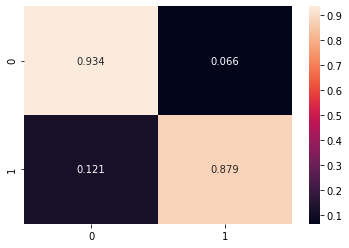

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_true, y_pred, normalize="true")

sns.heatmap(cm, annot=True, fmt=".3f");

In [13]:
data['text_clean'].loc[1]

['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada']